This notebook is based on kaggle kernel: https://www.kaggle.com/selfishgene/generating-sentences-one-letter-at-a-time

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
matplotlib.style.use('fivethirtyeight')

In [2]:
print('load and organize data')
data = pd.read_csv('data/spooky_author/train.csv')

stratifiedCV = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=1)
trainInds, validInds = next(stratifiedCV.split(data['text'], data['author']))

trainText  = data.loc[trainInds,'text'].reset_index(drop=True)
validText  = data.loc[validInds,'text'].reset_index(drop=True)
trainLabel = data.loc[trainInds,'author'].reset_index(drop=True)
validLabel = data.loc[validInds,'author'].reset_index(drop=True)

load and organize data


In [3]:
print('Collect all chars into one large string for each author')
charsDict = {}
for key in ['all','EAP','HPL','MWS']:
    charsDict[key] = []

for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    # the decoding is done for spanish/greek chars to be converted to close english chars
    decodedSentence = sentence.lower()
    chars = [char for char in decodedSentence]
    
    charsDict['all']  += chars
    charsDict[author] += chars

Collect all chars into one large string for each author


Show the Char usage Distribution for each Author


([<matplotlib.axis.XTick at 0x7f999c7fe748>,
 <a list of 57 Text xticklabel objects>)

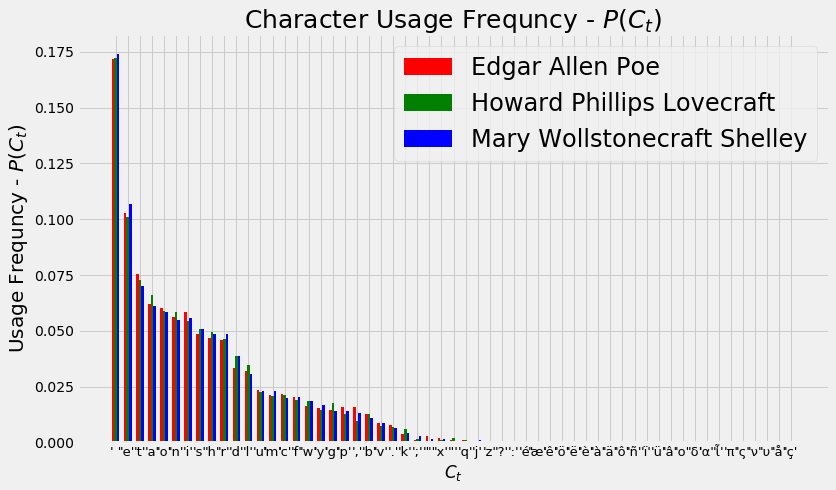

In [4]:
print('Show the Char usage Distribution for each Author')
charEncoder = preprocessing.LabelEncoder()
charEncoder.fit(charsDict['all'])

charCounts_EAP = np.histogram(charEncoder.transform(charsDict['EAP']),range(len(charEncoder.classes_)+1),density=True)[0]
charCounts_HPL = np.histogram(charEncoder.transform(charsDict['HPL']),range(len(charEncoder.classes_)+1),density=True)[0]
charCounts_MWS = np.histogram(charEncoder.transform(charsDict['MWS']),range(len(charEncoder.classes_)+1),density=True)[0]

# sort the char classes by their usage frequency
sortedChars = np.flipud(np.argsort(charCounts_EAP + charCounts_HPL + charCounts_MWS))

barWidth = 0.21
x = np.arange(len(charCounts_EAP))

plt.figure(figsize=(12,7)); plt.title('Character Usage Frequncy - $P(C_t)$ ',fontsize=25)
plt.bar(x-barWidth, charCounts_EAP[sortedChars], barWidth, color='r', label='Edgar Allen Poe')
plt.bar(x         , charCounts_HPL[sortedChars], barWidth, color='g', label='Howard Phillips Lovecraft')
plt.bar(x+barWidth, charCounts_MWS[sortedChars], barWidth, color='b', label='Mary Wollstonecraft Shelley')
plt.legend(fontsize=24); plt.ylabel('Usage Frequncy - $P(C_t)$', fontsize=20); plt.xlabel('$C_t$')
plt.xticks(x,["'%s'" %(charEncoder.classes_[i]) for i in sortedChars], fontsize=13)

Interestingly, there are differences between the authors here!

Lets look at the same plot only with log scale on the y axis


([<matplotlib.axis.XTick at 0x7f999c3829b0>,
 <a list of 57 Text xticklabel objects>)

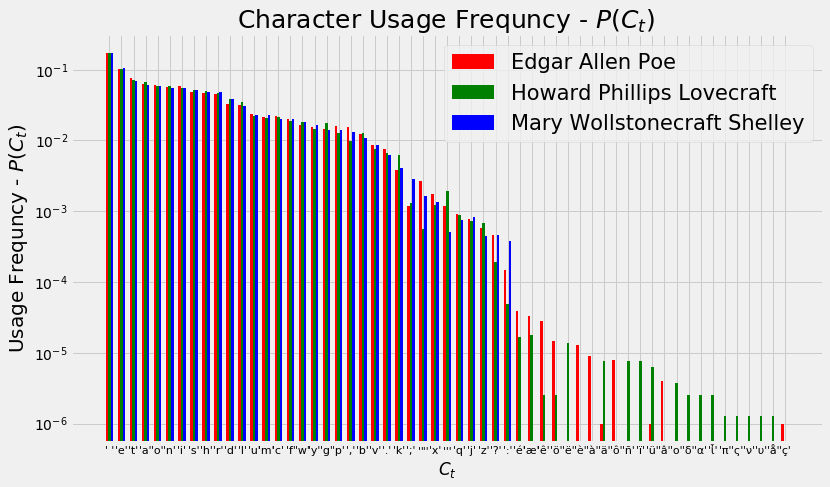

In [5]:
print('''Interestingly, there are differences between the authors here!

Lets look at the same plot only with log scale on the y axis''')

barWidth = 0.21
x = np.arange(len(charCounts_EAP))

plt.figure(figsize=(12,7)); 
plt.title('Character Usage Frequncy - $P(C_t)$ ',fontsize=25);
plt.bar(x-barWidth, charCounts_EAP[sortedChars], barWidth, color='r', label='Edgar Allen Poe')
plt.bar(x         , charCounts_HPL[sortedChars], barWidth, color='g', label='Howard Phillips Lovecraft')
plt.bar(x+barWidth, charCounts_MWS[sortedChars], barWidth, color='b', label='Mary Wollstonecraft Shelley')
plt.legend(fontsize=21); plt.ylabel('Usage Frequncy - $P(C_t)$', fontsize=20)
plt.yscale("log", nonposy='clip'); plt.xlabel('$C_t$')
plt.xticks(x,["'%s'" %(charEncoder.classes_[i]) for i in sortedChars], fontsize=11)

In [ ]:
print('meassure classification accuracy on validation set using only character frequncy')
authorsList = ['EAP','HPL','MWS']
authorPredictionList = []
for k, (sentence, author) in enumerate(zip(validText,validLabel)):
    chars = [char for char in sentence.lower()]
    # convert to log so we can sum probabilities instead of multiply
    logP_EAP = sum([np.log(charCounts_EAP[charEncoder.classes_ == ch]) for ch in chars])
    logP_HPL = sum([np.log(charCounts_HPL[charEncoder.classes_ == ch]) for ch in chars])
    logP_MWS = sum([np.log(charCounts_MWS[charEncoder.classes_ == ch]) for ch in chars])
    
    authorPredictionList.append(authorsList[np.argmax(np.array([logP_EAP,logP_HPL,logP_MWS]))])

print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

In [6]:
print("generate sample text by sampling one charachter at a time for the independent character model")
np.random.seed(1234)

maxSentenceLength = 95
numSentencesPerAuthor = 5

charProbModel = {}
charProbModel['all'] = (charCounts_EAP + charCounts_HPL + charCounts_MWS)/3.0
charProbModel['EAP'] = charCounts_EAP
charProbModel['HPL'] = charCounts_HPL
charProbModel['MWS'] = charCounts_MWS

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        generatedSentence = ''
        for j in range(maxSentenceLength):
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=charProbModel[author])][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
                
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

generate sample text by sampling one charachter at a time for the independent character model
-----------------------------------------------------------------------------------------------------
Author EAP:
------------
1: "."
2: "mfrrbcrvtehnoeih rtem etnerditfr ooatft , nli idh li mtryvrcmh."
3: "e fw  olh atei dfmtmo osnf iiuhhis nroriw  l ud."
4: "gttae,tootrlc en  dlsc" y,di twi eo ibwna rrptniaoutysiftwledtaoerromhsof eohen  o el ruwtmtoo "
5: "fce phnmefehxe ttemeaae npteceste   l d m sdpi in,rmimnarsoohsneie ksun e "i"ihtotcaotxndlsm cy"
-----------------------------------------------------------------------------------------------------
Author HPL:
------------
1: "ekia hyeo,   cirtnsloit r    hez dyetiutr viata owif lvwt."
2: "mee tn trdsh ffasolhhblpbi otiy, gtshtadoo clte hodstrbuuotahruntn seuh v n  nwope aq h,miisuao"
3: "oatiideewank ia t wde  em w,phrd go nelabts ntoh  s it nh   a e ttr."
4: "ltw donmsoe qe ot ,ee  f st afwr tse   t enlee eorat ta dsseaic mi pyreeeflm,

In [8]:
print('gather all pairs of characters into a single dataframe')
historyLength = 1

historyList  = []
nextCharList = []
authorList   = []
for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    decodedSentence = sentence.lower()
    charSequences   = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history    = [seq[:-1] for seq in charSequences]
    nextChar   = [seq[ -1] for seq in charSequences]
    sentenceDF = pd.DataFrame(columns=['author','history','next char'])
    
    historyList  += history
    nextCharList += nextChar
    authorList   += [author]*len(history)
        
corpusDF = pd.DataFrame(columns=['author','history','next char'])
corpusDF['author']    = authorList
corpusDF['history']   = historyList
corpusDF['next char'] = nextCharList

print(corpusDF.head(8))

gather all pairs of characters into a single dataframe
  author history next char
0    EAP       t         h
1    EAP       h         e
2    EAP       e          
3    EAP                 w
4    EAP       w         e
5    EAP       e         a
6    EAP       a         t
7    EAP       t         h


In [9]:
print('generate P(c(t)|c(t-1)) model (Markov Model with memory of 1 time step)')
charCondProbModel_H1 = {}
for author in ['EAP','HPL','MWS']:
    charCondProbModel_H1[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )
    
charCondCountModel_H1 = {}
for author in ['EAP','HPL','MWS']:
    charCondCountModel_H1[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )

corpusGroupedByAuthor = corpusDF.groupby(by='author',axis=0)
for author in corpusDF['author'].unique():
    authorCorpusDF = corpusGroupedByAuthor.get_group(author).loc[:,['history','next char']].reset_index(drop=True)
    authorCorpusGroupedByHistory = authorCorpusDF.groupby(by='history',axis=0)
    for history in authorCorpusDF['history'].unique():
        authorHistoryDF = authorCorpusGroupedByHistory.get_group(history).reset_index(drop=True).loc[:,'next char'].reset_index(drop=True)

        encodedHistory = charEncoder.transform([history])[0]
        encodedNextCharCounts = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=False)[0]
        encodedNextCharProb   = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=True)[0]

        charCondProbModel_H1[author][encodedHistory,:]  = encodedNextCharProb
        charCondCountModel_H1[author][encodedHistory,:] = encodedNextCharCounts

    condCount = charCondCountModel_H1[author]
    print('%s Sparsity level = %.1f%s' %(author, 100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

charCondProbModel_H1['all']  = (charCondProbModel_H1['EAP']  + charCondProbModel_H1['HPL']  + charCondProbModel_H1['MWS'] )/3.0
charCondCountModel_H1['all'] =  charCondCountModel_H1['EAP'] + charCondCountModel_H1['HPL'] + charCondCountModel_H1['MWS']

print('average Sparsity level = %.1f%s' %(100*(charCondCountModel_H1['all'] < 1).sum() / (condCount > -1).sum().astype(float),'%'))

generate P(c(t)|c(t-1)) model (Markov Model with memory of 1 time step)
EAP Sparsity level = 72.9%
MWS Sparsity level = 78.1%
HPL Sparsity level = 74.6%
average Sparsity level = 69.6%


([<matplotlib.axis.YTick at 0x7f999c5d4518>,
 <a list of 57 Text yticklabel objects>)

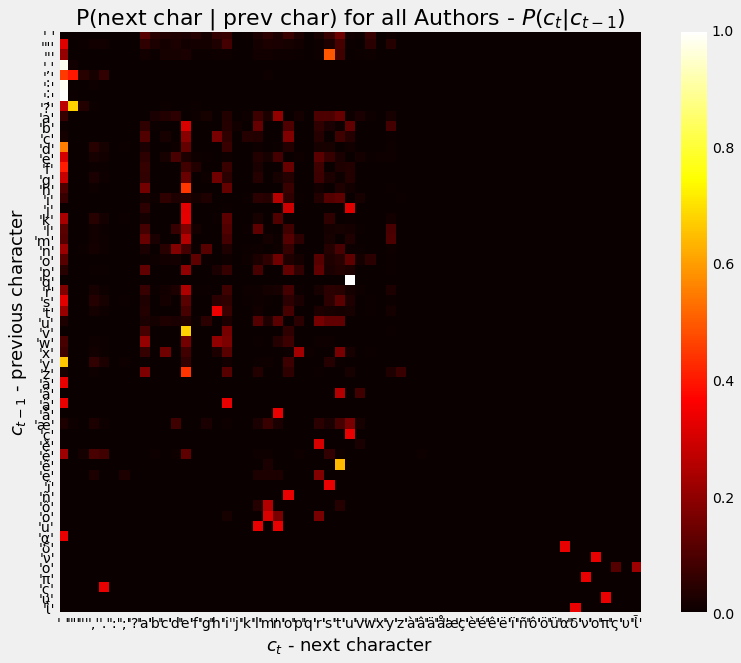

In [10]:
condProb = charCondProbModel_H1['all']

plt.figure(figsize=(12,10))
plt.imshow(condProb, cmap='hot')
plt.colorbar()
plt.clim(0,1)
plt.grid('off')
plt.title('P(next char | prev char) for all Authors - $P(c_t|c_{t-1})$', fontsize=22)
plt.xlabel('$c_t$ - next character', fontsize=18)
plt.ylabel('$c_{t-1}$ - previous character', fontsize=18)
plt.xticks(range(condProb.shape[0]),["'%s'" %(ch) for ch in charEncoder.classes_])
plt.yticks(range(condProb.shape[0]),["'%s'" %(ch) for ch in charEncoder.classes_])

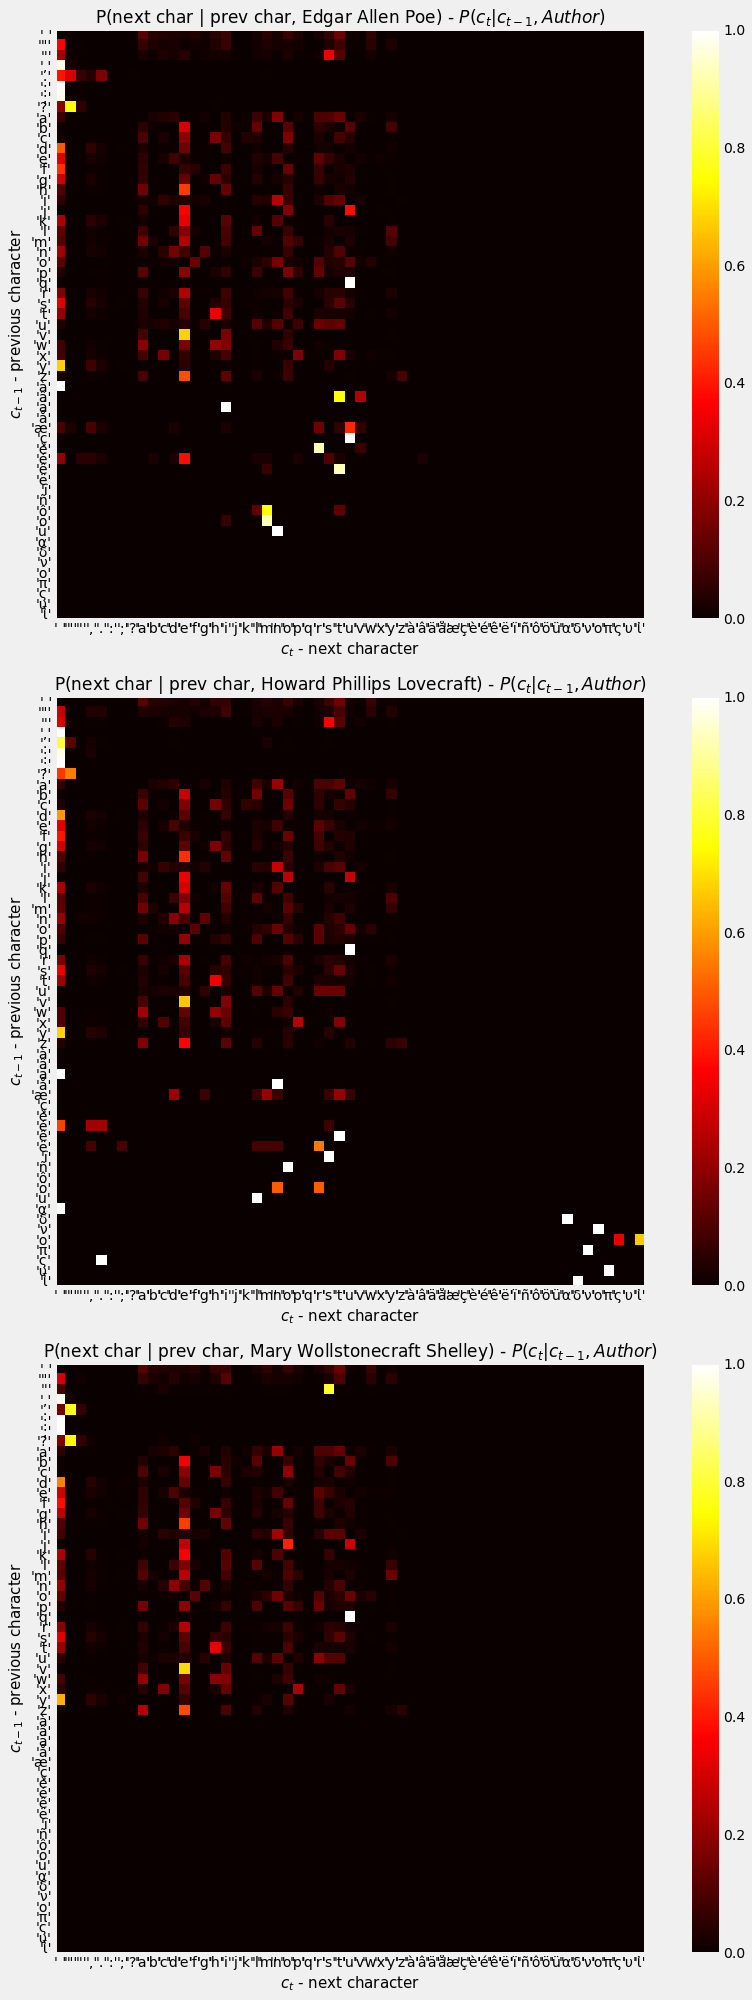

In [11]:
shortToFullNameDict = {}
shortToFullNameDict['EAP'] = 'Edgar Allen Poe'
shortToFullNameDict['HPL'] = 'Howard Phillips Lovecraft'
shortToFullNameDict['MWS'] = 'Mary Wollstonecraft Shelley'

plt.figure(figsize=(13,28))
for k, author in enumerate(['EAP','HPL','MWS']):
    condProb = charCondProbModel_H1[author]
    plt.subplot(3,1,k+1)
    plt.imshow(condProb, cmap='hot'); 
    plt.grid('off')
    plt.colorbar()
    plt.clim(0,1)
    plt.title('P(next char | prev char, %s) - $P(c_t|c_{t-1},Author)$' %(shortToFullNameDict[author]), fontsize=17);
    plt.xlabel('$c_t$ - next character', fontsize=15)
    plt.ylabel('$c_{t-1}$ - previous character', fontsize=15);
    plt.xticks(range(condProb.shape[0]),["'%s'" %(ch) for ch in charEncoder.classes_])
    plt.yticks(range(condProb.shape[0]),["'%s'" %(ch) for ch in charEncoder.classes_]);
plt.tight_layout()

In [13]:
print('meassure classification accuracy on validation set using Markov Model with memory of 1 time step')
uniformPriorFraction    = 0.0001
allAuthorsPriorFraction = 0.0001

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/len(charEncoder.classes_)

condP_H1 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H1[author]  = prior[0]*charCondProbModel_H1[author]
    condP_H1[author] += prior[1]*charCondProbModel_H1['all']
    condP_H1[author] += prior[2]*uniformPriorValue

authorPredictionList = []
for k, (sentence, author) in enumerate(zip(validText,validLabel)):
    decodedSentence = sentence.lower()
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
    for histChar, nextChar in zip(history,nextChar):
        encodedHistChar = charEncoder.transform([histChar])[0]
        encodedNextChar = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H1['EAP'][encodedHistChar,encodedNextChar])
        logP_HPL += np.log(condP_H1['HPL'][encodedHistChar,encodedNextChar])
        logP_MWS += np.log(condP_H1['MWS'][encodedHistChar,encodedNextChar])
    
    authorPredictionList.append(authorsList[np.argmax([logP_EAP,logP_HPL,logP_MWS])])
    
print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

meassure classification accuracy on validation set using Markov Model with memory of 1 time step


ValueError: y contains new labels: ['î']

In [14]:
print('generate sample text by sampling one charachter at a time from the 1 time step memory Markov Model')
np.random.seed(123)

maxSentenceLength = 90
numSentencesPerAuthor = 6

uniformPriorFraction    = 0.0001
allAuthorsPriorFraction = 0.0009

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/(len(charEncoder.classes_))

condP_H1 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H1[author]  = prior[0]*charCondProbModel_H1[author]
    condP_H1[author] += prior[1]*charCondProbModel_H1['all']
    condP_H1[author] += prior[2]*uniformPriorValue

condP_H1['all']  = (prior[0]+prior[1])*charCondProbModel_H1['all']
condP_H1['all'] += prior[2]*uniformPriorValue

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        firstChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=charProbModel[author])][0]
        generatedSentence = firstChar
        for j in range(maxSentenceLength-1):
            encodedHistChar = charEncoder.transform([generatedSentence[-1]])[0]
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=condP_H1[author][encodedHistChar,:])][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

generate sample text by sampling one charachter at a time from the 1 time step memory Markov Model
------------------------------------------------------------------------------------------------
Author EAP:
------------
1: "of orexple, i, s cingoris, d pand imesthe hes my o, oncecounghens tafe the on brdegatol ga"
2: "oxcoor igang bensere'e tefee wof mutapreparsubjed, freder st te r rsondeibotespos toud bin"
3: "icerer oupende p se n py."
4: "k si thered hiecuits lim e ert gupo my anterof, ieves fa y ie d pea he ofi t bt sutitholy "
5: "ust o s aiteeifenandrgthe my andi veshimeas."
6: "autenag."
------------------------------------------------------------------------------------------------
Author HPL:
------------
1: "dlorve alackeg s fooliourasquseraly thanor amy f d dinctes sed aly he bese wilysare ald cu"
2: " pheata vigh."
3: " thet; artheesifod ofomaz, as aror falockyof wnthieat the verste."
4: "lethemey d bere wh re osld ngasi our, t t nd qusese bthe, wesitowisorng mofand ndan 

# Build Markov Model that remebers the Two previous chars

In [15]:
print('generate P(c(t)|c(t-1),c(t-2)) model (Markov Model with memory of 2 time steps)')
historyLength = 2

charCondProbModel_H2 = {}
for author in ['EAP','HPL','MWS']:
    charCondProbModel_H2[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )
    
charCondCountModel_H2 = {}
for author in ['EAP','HPL','MWS']:
    charCondCountModel_H2[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )

corpusGroupedByAuthor = corpusDF.groupby(by='author',axis=0)
for author in corpusDF['author'].unique():
    authorCorpusDF = corpusGroupedByAuthor.get_group(author).loc[:,['history','next char']].reset_index(drop=True)
    authorCorpusGroupedByHistory = authorCorpusDF.groupby(by='history',axis=0)
    for history in authorCorpusDF['history'].unique():
        authorHistoryDF = authorCorpusGroupedByHistory.get_group(history).reset_index(drop=True).loc[:,'next char'].reset_index(drop=True)

        encodedHistory = charEncoder.transform([ch for ch in history])
        encodedNextCharCounts = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=False)[0]
        encodedNextCharProb   = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=True)[0]

        charCondProbModel_H2[author][encodedHistory[0],encodedHistory[1],:]  = encodedNextCharProb
        charCondCountModel_H2[author][encodedHistory[0],encodedHistory[1],:] = encodedNextCharCounts

    condCount = charCondCountModel_H2[author]
    print('%s Sparsity level = %.1f%s' %(author, 100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

charCondProbModel_H2['all']  = (charCondProbModel_H2['EAP']  + charCondProbModel_H2['HPL']  + charCondProbModel_H2['MWS'] )/3.0
charCondCountModel_H2['all'] =  charCondCountModel_H2['EAP'] + charCondCountModel_H2['HPL'] + charCondCountModel_H2['MWS']

condCount = charCondCountModel_H2['all']
print('average Sparsity level = %.1f%s' %(100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

generate P(c(t)|c(t-1),c(t-2)) model (Markov Model with memory of 2 time steps)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [16]:
#%% meassure classification accuracy on validation set using Markov Model with memory of 2 time steps
uniformPriorFraction    = 0.0001
allAuthorsPriorFraction = 0.0001

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/len(charEncoder.classes_)

condP_H2 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H2[author]  = prior[0]*charCondProbModel_H2[author]
    condP_H2[author] += prior[1]*charCondProbModel_H2['all']
    condP_H2[author] += prior[2]*uniformPriorValue

authorPredictionList = []
for k, (sentence, author) in enumerate(zip(validText,validLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
    for histChars, nextChar in zip(history,nextChar):
        encodedHistChars = charEncoder.transform([ch for ch in histChars])
        encodedNextChar  = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H2['EAP'][encodedHistChars[0],encodedHistChars[1],encodedNextChar])
        logP_HPL += np.log(condP_H2['HPL'][encodedHistChars[0],encodedHistChars[1],encodedNextChar])
        logP_MWS += np.log(condP_H2['MWS'][encodedHistChars[0],encodedHistChars[1],encodedNextChar])
    
    authorPredictionList.append(authorsList[np.argmax([logP_EAP,logP_HPL,logP_MWS])])

print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

KeyError: 'all'

In [17]:
#%% generate sample text by sampling one charachter at a time from the 2 time step Markov Model
np.random.seed(1000)

maxSentenceLength = 95
numSentencesPerAuthor = 9

uniformPriorFraction    = 0.0001
allAuthorsPriorFraction = 0.0009

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/(len(charEncoder.classes_))

condP_H2 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H2[author]  = prior[0]*charCondProbModel_H2[author]
    condP_H2[author] += prior[1]*charCondProbModel_H2['all']
    condP_H2[author] += prior[2]*uniformPriorValue

condP_H2['all']  = (prior[0]+prior[1])*charCondProbModel_H2['all']
condP_H2['all'] += prior[2]*uniformPriorValue

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        firstChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=charProbModel[author])][0]
        encodedFirstChar = charEncoder.transform([firstChar])[0]
        secondChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=condP_H1[author][encodedFirstChar,:])][0]
        generatedSentence = firstChar + secondChar
        
        for j in range(maxSentenceLength-1):
            encodedHistChars = charEncoder.transform([ch for ch in generatedSentence[-2:]])            
            currCondProb = condP_H2[author][encodedHistChars[0],encodedHistChars[1],:]
            currCondProb = currCondProb/currCondProb.sum() # just in case the probabilities don't sum directly to 1
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=currCondProb)][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

KeyError: 'all'

# Let's Repeat the process with History size of 3 chars

In [19]:
#%% gather all quadruplets of characters into a single dataframe
historyLength = 3

historyList  = []
nextCharList = []
authorList   = []
for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    decodedSentence = sentence.lower()
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    sentenceDF = pd.DataFrame(columns=['author','history','next char'])
    
    historyList  += history
    nextCharList += nextChar
    authorList   += [author]*len(history)
        
corpusDF = pd.DataFrame(columns=['author','history','next char'])
corpusDF['author']    = authorList
corpusDF['history']   = historyList
corpusDF['next char'] = nextCharList

corpusDF.head(8)

,author,history,next char
0,EAP,the,
1,EAP,he,w
2,EAP,e w,e
3,EAP,we,a
4,EAP,wea,t
5,EAP,eat,h
6,EAP,ath,e
7,EAP,the,r


In [20]:
#%% generate P(c(t)|c(t-1),c(t-2),c(t-3)) model (Markov Model with memory of 3 time steps)
historyLength = 3

charCondProbModel_H3 = {}
for author in ['EAP','HPL','MWS']:
    charCondProbModel_H3[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )
    
charCondCountModel_H3 = {}
for author in ['EAP','HPL','MWS']:
    charCondCountModel_H3[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )

corpusGroupedByAuthor = corpusDF.groupby(by='author',axis=0)
for author in corpusDF['author'].unique():
    authorCorpusDF = corpusGroupedByAuthor.get_group(author).loc[:,['history','next char']].reset_index(drop=True)
    authorCorpusGroupedByHistory = authorCorpusDF.groupby(by='history',axis=0)
    for history in authorCorpusDF['history'].unique():
        authorHistoryDF = authorCorpusGroupedByHistory.get_group(history).reset_index(drop=True).loc[:,'next char'].reset_index(drop=True)

        encodedHistory = charEncoder.transform([ch for ch in history])
        encodedNextCharCounts = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=False)[0]
        encodedNextCharProb   = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=True)[0]

        charCondProbModel_H3[author][encodedHistory[0],encodedHistory[1],encodedHistory[2],:]  = encodedNextCharProb
        charCondCountModel_H3[author][encodedHistory[0],encodedHistory[1],encodedHistory[2],:] = encodedNextCharCounts

    condCount = charCondCountModel_H3[author]
    print('%s Sparsity level = %.1f%s' %(author, 100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

charCondProbModel_H3['all']  = (charCondProbModel_H3['EAP']  + charCondProbModel_H3['HPL']  + charCondProbModel_H3['MWS'] )/3.0
charCondCountModel_H3['all'] =  charCondCountModel_H3['EAP'] + charCondCountModel_H3['HPL'] + charCondCountModel_H3['MWS']

condCount = charCondCountModel_H3['all']
print('average Sparsity level = %.1f%s' %(100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

EAP Sparsity level = 99.7%
MWS Sparsity level = 99.8%
HPL Sparsity level = 99.7%
average Sparsity level = 99.6%


In [22]:
#%% meassure classification accuracy on validation set using Markov Model with memory of 3 time steps
uniformPriorFraction    = 0.05
allAuthorsPriorFraction = 0.05

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/(len(charEncoder.classes_))

condP_H3 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H3[author]  = prior[0]*charCondProbModel_H3[author]
    condP_H3[author] += prior[1]*charCondProbModel_H3['all']
    condP_H3[author] += prior[2]*uniformPriorValue

condP_H3['all']  = (prior[0]+prior[1])*charCondProbModel_H3['all']
condP_H3['all'] += prior[2]*uniformPriorValue

authorPredictionList = []
for k, (sentence, author) in enumerate(zip(validText,validLabel)):
    decodedSentence = sentence.lower()
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
    for histChars, nextChar in zip(history,nextChar):
        encodedHistChars = charEncoder.transform([ch for ch in histChars])
        encodedNextChar  = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H3['EAP'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedNextChar])
        logP_HPL += np.log(condP_H3['HPL'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedNextChar])
        logP_MWS += np.log(condP_H3['MWS'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedNextChar])
    
    authorPredictionList.append(authorsList[np.argmax([logP_EAP,logP_HPL,logP_MWS])])

print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

ValueError: y contains new labels: ['î']

# Generate Sample Text for each Author using our 3 time step Markov Model

In [23]:
#%% generate sample text by sampling one charachter at a time from the 3 time step Markov Model
np.random.seed(123)

maxSentenceLength = 95
numSentencesPerAuthor = 9

uniformPriorFraction    = 0.05
allAuthorsPriorFraction = 0.05

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/(len(charEncoder.classes_))

condP_H3 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H3[author]  = prior[0]*charCondProbModel_H3[author]
    condP_H3[author] += prior[1]*charCondProbModel_H3['all']
    condP_H3[author] += prior[2]*uniformPriorValue

condP_H3['all']  = (prior[0]+prior[1])*charCondProbModel_H3['all']
condP_H3['all'] += prior[2]*uniformPriorValue

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        # sample c(1) ~ P(c(t))
        firstChar  = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=charProbModel[author])][0]
        encodedFirstChar = charEncoder.transform([firstChar])[0]
        # sample c(2) ~ P(c(t)|c(t-1))
        secondChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=condP_H1[author][encodedFirstChar,:])][0]
        encodedSecondChar = charEncoder.transform([secondChar])[0]
        # sample c(3) ~ P(c(t)|c(t-1),c(t-2))
        thirdChar  = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=condP_H2[author][encodedFirstChar,encodedSecondChar,:])][0]
        generatedSentence = firstChar + secondChar + thirdChar
        
        for j in range(maxSentenceLength-1):
            encodedHistChars = charEncoder.transform([ch for ch in generatedSentence[-historyLength:]])            
            currCondProb = condP_H3[author][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],:]
            currCondProb = currCondProb/currCondProb.sum() # just in case the probabilities don't sum directly to 1
            
            # sample c(t) ~ P(c(t)|c(t-1),c(t-2),c(t-3))
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=currCondProb)][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

-----------------------------------------------------------------------------------------------------
Author EAP:
------------


ValueError: probabilities do not sum to 1

# Let's Repeat the process one last time with History size of 4 chars

In [25]:
#%% gather all 5-wise of characters into a single dataframe
historyLength = 4

historyList  = []
nextCharList = []
authorList   = []
for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    decodedSentence = sentence.lower()
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    sentenceDF = pd.DataFrame(columns=['author','history','next char'])
    
    historyList  += history
    nextCharList += nextChar
    authorList   += [author]*len(history)
        
corpusDF = pd.DataFrame(columns=['author','history','next char'])
corpusDF['author']    = authorList
corpusDF['history']   = historyList
corpusDF['next char'] = nextCharList

print(corpusDF.head(15))

   author history next char
0     EAP    the          w
1     EAP    he w         e
2     EAP    e we         a
3     EAP     wea         t
4     EAP    weat         h
5     EAP    eath         e
6     EAP    athe         r
7     EAP    ther          
8     EAP    her          w
9     EAP    er w         a
10    EAP    r wa         s
11    EAP     was          
12    EAP    was          w
13    EAP    as w         a
14    EAP    s wa         r


## Build Markov Model that remebers the 4 previous chars

In [ ]:
#%% generate P(c(t)|c(t-1),c(t-2),c(t-3),c(t-4)) model (Markov Model with memory of 4 time steps)
historyLength = 4

charCondProbModel_H4 = {}
for author in ['EAP','HPL','MWS']:
    charCondProbModel_H4[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )
    
charCondCountModel_H4 = {}
for author in ['EAP','HPL','MWS']:
    charCondCountModel_H4[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )

corpusGroupedByAuthor = corpusDF.groupby(by='author',axis=0)
for author in corpusDF['author'].unique():
    authorCorpusDF = corpusGroupedByAuthor.get_group(author).loc[:,['history','next char']].reset_index(drop=True)
    authorCorpusGroupedByHistory = authorCorpusDF.groupby(by='history',axis=0)
    for history in authorCorpusDF['history'].unique():
        authorHistoryDF = authorCorpusGroupedByHistory.get_group(history).reset_index(drop=True).loc[:,'next char'].reset_index(drop=True)

        encodedHistory = charEncoder.transform([ch for ch in history])
        encodedNextCharCounts = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=False)[0]
        encodedNextCharProb   = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=True)[0]

        charCondProbModel_H4[author][encodedHistory[0],encodedHistory[1],encodedHistory[2],encodedHistory[3],:]  = encodedNextCharProb
        charCondCountModel_H4[author][encodedHistory[0],encodedHistory[1],encodedHistory[2],encodedHistory[3],:] = encodedNextCharCounts

    condCount = charCondCountModel_H4[author]
    print('%s Sparsity level = %.2f%s' %(author, 100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

charCondProbModel_H4['all']  = (charCondProbModel_H4['EAP']  + charCondProbModel_H4['HPL']  + charCondProbModel_H4['MWS'] )/3.0
charCondCountModel_H4['all'] =  charCondCountModel_H4['EAP'] + charCondCountModel_H4['HPL'] + charCondCountModel_H4['MWS']

condCount = charCondCountModel_H4['all']
print('average Sparsity level = %.2f%s' %(100*((condCount < 1).sum() / (condCount > -1).sum().astype(float)),'%'))

EAP Sparsity level = 99.98%
MWS Sparsity level = 99.99%
HPL Sparsity level = 99.99%


Calculate Classification Accuracy of Markov Model that remebers 4 time steps back

In [27]:
#%% meassure classification accuracy on validation set using Markov Model with memory of 4 time steps
condP_H4_PriorWeight_specific = 70
condP_H4_PriorWeight_all      = 30

condP_H3_PriorWeight_specific = 70
condP_H3_PriorWeight_all      = 30

uniformPriorWeight            = 10

logP_EAP_prior = np.log((trainLabel == 'EAP').mean())
logP_HPL_prior = np.log((trainLabel == 'HPL').mean())
logP_MWS_prior = np.log((trainLabel == 'MWS').mean())

numChars = len(charEncoder.classes_)
prior = np.array([condP_H4_PriorWeight_specific, condP_H4_PriorWeight_all, 
                  condP_H3_PriorWeight_specific, condP_H3_PriorWeight_all, uniformPriorWeight])
prior = prior.astype(float) / prior.sum()

uniformPriorValue = 1.0/numChars

condP_H4 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    # get P(c(t)|c(t-1),c(t-2),c(t-3),c(t-4))
    condP_H4[author]  = prior[0]*charCondProbModel_H4[author]
    condP_H4[author] += prior[1]*charCondProbModel_H4['all']
    
    # get "prior" from P(c(t)|c(t-1),c(t-2),c(t-3))
    condP_H4_from_CondP_H3_specific = np.tile(charCondProbModel_H3[author][np.newaxis,:,:,:],[numChars,1,1,1,1])
    condP_H4_from_CondP_H3_all      = np.tile(charCondProbModel_H3['all'][np.newaxis,:,:,:],[numChars,1,1,1,1])
    condP_H4[author] += prior[2]*condP_H4_from_CondP_H3_specific
    condP_H4[author] += prior[3]*condP_H4_from_CondP_H3_all

    condP_H4[author] += prior[4]*uniformPriorValue

condP_H4['all']  = (condP_H4['EAP'] + condP_H4['HPL'] + condP_H4['MWS'])  / 3.0

authorPredictionList = []
logProbGivenAuthor = np.zeros((len(validLabel),3))
for i, (sentence, author) in enumerate(zip(validText,validLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = logP_EAP_prior; logP_HPL = logP_HPL_prior; logP_MWS = logP_MWS_prior;
    for histChars, nextChar in zip(history,nextChar):
        encodedHistChars = charEncoder.transform([ch for ch in histChars])
        encodedNextChar  = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H4['EAP'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        logP_HPL += np.log(condP_H4['HPL'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        logP_MWS += np.log(condP_H4['MWS'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        
        logProbGivenAuthor[i,:] = [logP_EAP,logP_HPL,logP_MWS]
        
    authorPredictionList.append(authorsList[np.argmax([logP_EAP,logP_HPL,logP_MWS])])

print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

MemoryError: 

Let's calculate also the log loss

In [28]:
#%% calculate log loss
minimalLogP = -15.0
uniformPriorWeight = 0.09

authorLogProb_norm = logProbGivenAuthor - np.tile(logProbGivenAuthor.max(axis=1)[:,np.newaxis], [1,3])
authorLogProb_norm[authorLogProb_norm < minimalLogP] = minimalLogP

authorProb = np.exp(authorLogProb_norm)
authorProb_norm = authorProb / np.tile(authorProb.sum(axis=1)[:,np.newaxis],[1, 3])

y_Hat = uniformPriorWeight*(1/3.0) + (1.0-uniformPriorWeight)*authorProb_norm

labelEncoder = preprocessing.LabelEncoder()
y_GT = labelEncoder.fit_transform(validLabel)

print(34*'-')
print('Validation Set Log Loss = %.5f' %(log_loss(y_GT, y_Hat)))
print(34*'-')

NameError: name 'logProbGivenAuthor' is not defined

Generate Sample Text for each Author using our 4 time step Markov Model

In [29]:
np.random.seed(1000)

maxSentenceLength = 95
numSentencesPerAuthor = 9

condP_H4_PriorWeight_specific = 10
condP_H4_PriorWeight_all      = 10

condP_H3_PriorWeight_specific = 1
condP_H3_PriorWeight_all      = 1

uniformPriorWeight            = 1

numChars = len(charEncoder.classes_)
prior = np.array([condP_H4_PriorWeight_specific, condP_H4_PriorWeight_all, 
                  condP_H3_PriorWeight_specific, condP_H3_PriorWeight_all, uniformPriorWeight])
prior = prior.astype(float) / prior.sum()

uniformPriorValue = 1.0/numChars

condP_H4 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    # get P(c(t)|c(t-1),c(t-2),c(t-3),c(t-4))
    condP_H4[author]  = prior[0]*charCondProbModel_H4[author]
    condP_H4[author] += prior[1]*charCondProbModel_H4['all']
    
    # get prior from P(c(t)|c(t-1),c(t-2),c(t-3))
    condP_H4_from_CondP_H3_specific = np.tile(charCondProbModel_H3[author][np.newaxis,:,:,:],[numChars,1,1,1,1])
    condP_H4_from_CondP_H3_all      = np.tile(charCondProbModel_H3['all'][np.newaxis,:,:,:],[numChars,1,1,1,1])
    condP_H4[author] += prior[2]*condP_H4_from_CondP_H3_specific
    condP_H4[author] += prior[3]*condP_H4_from_CondP_H3_all

    condP_H4[author] += prior[4]*uniformPriorValue

condP_H4['all']  = (condP_H4['EAP'] + condP_H4['HPL'] + condP_H4['MWS'])  / 3.0

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        generatedSentence = 'disp'
        for j in range(maxSentenceLength-1):
            encodedHistChars = charEncoder.transform([ch for ch in generatedSentence[-historyLength:]])            
            currCondProb = condP_H4[author][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],:]
            currCondProb = currCondProb/currCondProb.sum() # just in case the probabilities don't sum exactly to 1
            
            # sample c(t) ~ P(c(t)|c(t-1),c(t-2),c(t-3))
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=currCondProb)][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

MemoryError: 

# Create a Submission on the Test Set

In [31]:
#%% create a submission
# load test data
testData = pd.read_csv('data/spooky_author/test.csv')
testText = testData.loc[:,'text'].reset_index(drop=True)

# calculate log prob predictions
logProbGivenAuthor = np.zeros((len(testText),3))
for i, sentence in enumerate(testText):
    decodedSentence = sentence.lower()
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = logP_EAP_prior; logP_HPL = logP_HPL_prior; logP_MWS = logP_MWS_prior;
    for histChars, nextChar in zip(history,nextChar):
        encodedHistChars = charEncoder.transform([ch for ch in histChars])
        encodedNextChar  = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H4['EAP'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        logP_HPL += np.log(condP_H4['HPL'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        logP_MWS += np.log(condP_H4['MWS'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
    
        logProbGivenAuthor[i,:] = [logP_EAP,logP_HPL,logP_MWS]

KeyError: 'HPL'

In [32]:
print('convert log probabilities to final predictions')
minimalLogP = -15.0
uniformPriorWeight = 0.09

authorLogProb_norm = logProbGivenAuthor - np.tile(logProbGivenAuthor.max(axis=1)[:,np.newaxis], [1,3])
authorLogProb_norm[authorLogProb_norm < minimalLogP] = minimalLogP
authorProb = np.exp(authorLogProb_norm)
authorProb_norm = authorProb / np.tile(authorProb.sum(axis=1)[:,np.newaxis],[1, 3])
y_Hat = uniformPriorWeight*(1/3.0) + (1.0-uniformPriorWeight)*authorProb_norm

# write a submission
submission = pd.read_csv('data/spooky_author/sample_submission.csv')
submission.loc[:,['EAP', 'HPL', 'MWS']] = y_Hat
submission.to_csv("Markov_char_given_4charHistory.csv", index=False)
print(submission.head(10))

convert log probabilities to final predictions
        id       EAP       HPL       MWS
0  id02310  0.333333  0.333333  0.333333
1  id24541  0.333333  0.333333  0.333333
2  id00134  0.333333  0.333333  0.333333
3  id27757  0.333333  0.333333  0.333333
4  id04081  0.333333  0.333333  0.333333
5  id27337  0.333333  0.333333  0.333333
6  id24265  0.333333  0.333333  0.333333
7  id25917  0.333333  0.333333  0.333333
8  id04951  0.333333  0.333333  0.333333
9  id14549  0.333333  0.333333  0.333333


## Apply Fully Discriminative Approach

1. Extract Bag of Character n-grams features
1. Create a submission for Logistic Regression over BagOfChar
1. Extract Bag of Word n-grams features
1. Create a submission for Logistic Regression over BagOfWord
1. Create a submission for Logistic Regression over both BagOfWord and BagOfChar

In [33]:
import time
import scipy
import warnings
warnings.filterwarnings("ignore")

#%% Create a Bag of Char n-grams + logistic regression model
ngramLength = 5

featureExtractionStartTime = time.time()
print('-'*52)
print('fitting "CountVectorizer()" for bag of char %d-grams' %(ngramLength))

BagOfCharsExtractor = CountVectorizer(min_df=8, max_features=250000, 
                                      analyzer='char', ngram_range=(1,ngramLength), 
                                      binary=False,lowercase=True)

BagOfCharsExtractor.fit(pd.concat((trainText,validText,testText)))

X_train_char = BagOfCharsExtractor.transform(trainText)
X_valid_char = BagOfCharsExtractor.transform(validText)
X_test_char  = BagOfCharsExtractor.transform(testText)

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))
print('number of "bag of char %d-gram" features = %d' %(ngramLength, X_train_char.shape[1]))
print('-'*52)

# scale inputs so that they will be in similar value range
stdScaler = preprocessing.StandardScaler(with_mean=False)
stdScaler.fit(scipy.sparse.vstack(((X_train_char,X_valid_char,X_test_char))))

X_train_norm = stdScaler.transform(X_train_char)
X_valid_norm = stdScaler.transform(X_valid_char)
X_test_norm  = stdScaler.transform(X_test_char)

# create labels for classification
yLabelEncoder = preprocessing.LabelEncoder()
yLabelEncoder.fit(pd.concat((trainLabel,validLabel)))

y_train = yLabelEncoder.transform(trainLabel)
y_valid = yLabelEncoder.transform(validLabel)

##%% check performance on validation set
validationStartTime = time.time()
print('-'*42)
print('fitting "LogisticRegression()" classifier')

logisticRegressor_char = linear_model.LogisticRegression(C=0.01, solver='sag')
logisticRegressor_char.fit(X_train_norm, y_train)

trainAccuracy = accuracy_score(y_train, logisticRegressor_char.predict(X_train_norm))
validAccuracy = accuracy_score(y_valid, logisticRegressor_char.predict(X_valid_norm))
trainLogLoss  = log_loss(y_train, logisticRegressor_char.predict_proba(X_train_norm))
validLogLoss  = log_loss(y_valid, logisticRegressor_char.predict_proba(X_valid_norm))

validationDurationInMinutes = (time.time()-validationStartTime)/60.0

print('Validation took %.2f minutes' % (validationDurationInMinutes))
print('Train: %.1f%s Accuracy, log loss = %.4f' % (100*trainAccuracy,'%',trainLogLoss))
print('Valid: %.1f%s Accuracy, log loss = %.4f' % (100*validAccuracy,'%',validLogLoss))
print('-'*42)

----------------------------------------------------
fitting "CountVectorizer()" for bag of char 5-grams
feature extraction took 0.76 minutes
number of "bag of char 5-gram" features = 82728
----------------------------------------------------
------------------------------------------
fitting "LogisticRegression()" classifier
Validation took 0.81 minutes
Train: 99.4% Accuracy, log loss = 0.1369
Valid: 86.4% Accuracy, log loss = 0.3722
------------------------------------------


In [34]:
# write a submission
submission = pd.read_csv('data/spooky_author/sample_submission.csv')
submission.loc[:,yLabelEncoder.classes_.tolist()] = logisticRegressor_char.predict_proba(X_test_norm)
submission.to_csv("LogisticRegression_Over_BagOfCharNGrams.csv", index=False)
print(submission.head(10))

        id       EAP       HPL       MWS
0  id02310  0.041425  0.032256  0.926318
1  id24541  0.998684  0.001284  0.000032
2  id00134  0.178390  0.819748  0.001862
3  id27757  0.478578  0.520888  0.000534
4  id04081  0.520076  0.222763  0.257161
5  id27337  0.961379  0.014409  0.024212
6  id24265  0.683593  0.268499  0.047908
7  id25917  0.000404  0.431460  0.568135
8  id04951  0.995705  0.004123  0.000172
9  id14549  0.745458  0.090373  0.164169


## Extract Bag of Word n-grams features and create a submission

In [35]:
ngramLength = 2

featureExtractionStartTime = time.time()
print('-'*52)
print('fitting "CountVectorizer()" for bag of word %d-grams' %(ngramLength))

BagOfWordsExtractor = CountVectorizer(min_df=5, max_features=250000, 
                                      analyzer='word', ngram_range=(1,ngramLength), 
                                      binary=False,lowercase=True)

BagOfWordsExtractor.fit(pd.concat((trainText,validText,testText)))

X_train_word = BagOfWordsExtractor.transform(trainText)
X_valid_word = BagOfWordsExtractor.transform(validText)
X_test_word  = BagOfWordsExtractor.transform(testText)

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))
print('number of "bag of word %d-gram" features = %d' %(ngramLength, X_train_word.shape[1]))
print('-'*52)

# scale inputs so that they will be in similar value range
stdScaler = preprocessing.StandardScaler(with_mean=False)
stdScaler.fit(scipy.sparse.vstack(((X_train_word,X_valid_word,X_test_word))))

X_train_norm = stdScaler.transform(X_train_word)
X_valid_norm = stdScaler.transform(X_valid_word)
X_test_norm  = stdScaler.transform(X_test_word)

#£%% check performance on validation set
validationStartTime = time.time()
print('-'*42)
print('fitting "LogisticRegression()" classifier')

logisticRegressor_word = linear_model.LogisticRegression(C=0.01, solver='sag')
logisticRegressor_word.fit(X_train_norm, y_train)

trainAccuracy = accuracy_score(y_train, logisticRegressor_word.predict(X_train_norm))
validAccuracy = accuracy_score(y_valid, logisticRegressor_word.predict(X_valid_norm))
trainLogLoss  = log_loss(y_train, logisticRegressor_word.predict_proba(X_train_norm))
validLogLoss  = log_loss(y_valid, logisticRegressor_word.predict_proba(X_valid_norm))

validationDurationInMinutes = (time.time()-validationStartTime)/60.0

print('Validation took %.2f minutes' % (validationDurationInMinutes))
print('Train: %.1f%s Accuracy, log loss = %.4f' % (100*trainAccuracy,'%',trainLogLoss))
print('Valid: %.1f%s Accuracy, log loss = %.4f' % (100*validAccuracy,'%',validLogLoss))
print('-'*42)

----------------------------------------------------
fitting "CountVectorizer()" for bag of word 2-grams
feature extraction took 0.14 minutes
number of "bag of word 2-gram" features = 29413
----------------------------------------------------
------------------------------------------
fitting "LogisticRegression()" classifier
Validation took 0.07 minutes
Train: 99.4% Accuracy, log loss = 0.1494
Valid: 83.1% Accuracy, log loss = 0.4445
------------------------------------------


In [36]:
# write a submission
submission = pd.read_csv('data/spooky_author/sample_submission.csv')
submission.loc[:,yLabelEncoder.classes_.tolist()] = logisticRegressor_word.predict_proba(X_test_norm)
submission.to_csv("LogisticRegression_Over_BagOfWordNGrams.csv", index=False)
print(submission.head(10))

        id       EAP       HPL       MWS
0  id02310  0.093544  0.061960  0.844496
1  id24541  0.967677  0.031826  0.000497
2  id00134  0.045477  0.902591  0.051931
3  id27757  0.678558  0.307255  0.014187
4  id04081  0.333118  0.387189  0.279693
5  id27337  0.932322  0.052319  0.015359
6  id24265  0.830711  0.104084  0.065205
7  id25917  0.076020  0.313505  0.610475
8  id04951  0.987690  0.008347  0.003963
9  id14549  0.657979  0.162518  0.179503


In [37]:
#%% combine word and char features

# combine and scale features 
X_train = scipy.sparse.hstack((X_train_word,X_train_char))
X_valid = scipy.sparse.hstack((X_valid_word,X_valid_char))
X_test  = scipy.sparse.hstack((X_test_word,X_test_char))

stdScaler = preprocessing.StandardScaler(with_mean=False)
stdScaler.fit(scipy.sparse.vstack(((X_train,X_valid,X_test))))

X_train = stdScaler.transform(X_train)
X_valid = stdScaler.transform(X_valid)
X_test  = stdScaler.transform(X_test)

##%% check performance on validation set

validationStartTime = time.time()
print('-'*42)
print('fitting "LogisticRegression()" classifier')

logisticRegressor = linear_model.LogisticRegression(C=0.01, solver='sag')
logisticRegressor.fit(X_train, y_train)

trainAccuracy = accuracy_score(y_train, logisticRegressor.predict(X_train))
trainLogLoss = log_loss(y_train, logisticRegressor.predict_proba(X_train))
validAccuracy = accuracy_score(y_valid, logisticRegressor.predict(X_valid))
validLogLoss = log_loss(y_valid, logisticRegressor.predict_proba(X_valid))

validationDurationInMinutes = (time.time()-validationStartTime)/60.0

print('Validation took %.2f minutes' % (validationDurationInMinutes))
print('Train: %.1f%s Accuracy, log loss = %.4f' % (100*trainAccuracy,'%',trainLogLoss))
print('Valid: %.1f%s Accuracy, log loss = %.4f' % (100*validAccuracy,'%',validLogLoss))
print('-'*42)

# write a submission
submission = pd.read_csv('data/spooky_author/sample_submission.csv')
submission.loc[:,yLabelEncoder.classes_.tolist()] = logisticRegressor.predict_proba(X_test)
submission.to_csv("LogisticRegression_Over_BagOfWord_BagOfChar.csv", index=False)
print(submission.head(10))

------------------------------------------
fitting "LogisticRegression()" classifier
Validation took 0.80 minutes
Train: 99.7% Accuracy, log loss = 0.1271
Valid: 87.3% Accuracy, log loss = 0.3620
------------------------------------------
        id       EAP       HPL       MWS
0  id02310  0.046772  0.034365  0.918863
1  id24541  0.997864  0.002079  0.000057
2  id00134  0.108331  0.887920  0.003749
3  id27757  0.496328  0.502691  0.000981
4  id04081  0.483164  0.260267  0.256569
5  id27337  0.966906  0.013192  0.019902
6  id24265  0.737597  0.212142  0.050260
7  id25917  0.001704  0.384108  0.614188
8  id04951  0.995262  0.004400  0.000338
9  id14549  0.745218  0.105219  0.149563
